In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import json
import random
from tqdm import tqdm

path = './Landsat/'
print(os.listdir(path))

['LC08_L2SP_197020_20240516_20240521_02_T1_ANG.txt', 'LC08_L2SP_197020_20240516_20240521_02_T1_MTL.txt', 'LC08_L2SP_197020_20240516_20240521_02_T1_MTL.xml', 'LC08_L2SP_197020_20240516_20240521_02_T1_QA_PIXEL.TIF', 'LC08_L2SP_197020_20240516_20240521_02_T1_QA_RADSAT.TIF', 'LC08_L2SP_197020_20240516_20240521_02_T1_SR_B1.TIF', 'LC08_L2SP_197020_20240516_20240521_02_T1_SR_B2.TIF', 'LC08_L2SP_197020_20240516_20240521_02_T1_SR_B3.TIF', 'LC08_L2SP_197020_20240516_20240521_02_T1_SR_B4.TIF', 'LC08_L2SP_197020_20240516_20240521_02_T1_SR_B5.TIF', 'LC08_L2SP_197020_20240516_20240521_02_T1_SR_B6.TIF', 'LC08_L2SP_197020_20240516_20240521_02_T1_SR_B7.TIF', 'LC08_L2SP_197020_20240516_20240521_02_T1_SR_QA_AEROSOL.TIF', 'LC08_L2SP_197021_20240516_20240521_02_T1_ANG.txt', 'LC08_L2SP_197021_20240516_20240521_02_T1_MTL.txt', 'LC08_L2SP_197021_20240516_20240521_02_T1_MTL.xml', 'LC08_L2SP_197021_20240516_20240521_02_T1_QA_PIXEL.TIF', 'LC08_L2SP_197021_20240516_20240521_02_T1_QA_RADSAT.TIF', 'LC08_L2SP_197021

In [2]:
# band 2: blue
# band 3: green
# band 4: red
# band 5: NIR
# band 6 + 7: SWIR1 + SWIR2

base_path = path + 'LC08_L2SP_197020_20240516_20240521_02_T1_SR_B{}.TIF'
channels = []

for num in range(2, 8):
    channel_path = base_path.format(num)
    channel_tif = rasterio.open(channel_path)
    channel = channel_tif.read()
    # The values of the RGB channels have range 0...65535, rescale to 0...255 so we can display as image
    channel_norm = np.clip(channel/65535.0, 0, 1)
    channels.append(channel_norm)

b, g, r, nir, swir1, swir2 = channels

img_rgb = np.stack((r, g, b), axis = -1).astype(np.float32)[0] # Remove first dimension with shape 1

img_full = np.stack((b, g, r, nir, swir1, swir2), axis = -1).astype(np.float32)[0].transpose(2,0,1)

bounds = channel_tif.bounds
print(img_rgb.shape)
print(img_full.shape)
print(bounds)
print(channel_tif.crs)
print(channel_tif.transform)

(8111, 8021, 3)
(6, 8111, 8021)
BoundingBox(left=407085.0, bottom=6229785.0, right=647715.0, top=6473115.0)
EPSG:32632
| 30.00, 0.00, 407085.00|
| 0.00,-30.00, 6473115.00|
| 0.00, 0.00, 1.00|


In [3]:
# Get the coordinate bounds in the same CRS as for the Danish data
import pyproj

source_crs = pyproj.CRS.from_epsg(32632)  
target_crs = pyproj.CRS.from_epsg(25832) 
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

left, bottom, right, top = bounds
transformer.transform(left, bottom), transformer.transform(right, top)


((407084.99999894405, 6229784.999875893),
 (647715.0000017629, 6473114.99987639))

In [4]:
# ANWDI
andwi = (b+g+r-nir-swir1-swir2) / (b+g+r+nir+swir1+swir2)
andwi[np.isnan(andwi)] = 0 # NaNs are replaced with 0

# NWDI
ndwi = (g-nir)/(g+nir)
ndwi[np.isnan(ndwi)] = 0 # NaNs are replaced with 0

# Make the indices into masks (0 or 1), using a threshold
mask_ndwi = ndwi >= 0
mask_ndwi = mask_ndwi[0] # Remove first dimension, which has shape 1
mask_andwi = andwi >= 0
mask_andwi = mask_andwi[0] # Remove first dimension, which has shape 1

/tmp/ipykernel_697836/645062751.py:2: RuntimeWarning: invalid value encountered in divide
  andwi = (b+g+r-nir-swir1-swir2) / (b+g+r+nir+swir1+swir2)
/tmp/ipykernel_697836/645062751.py:6: RuntimeWarning: invalid value encountered in divide
  ndwi = (g-nir)/(g+nir)


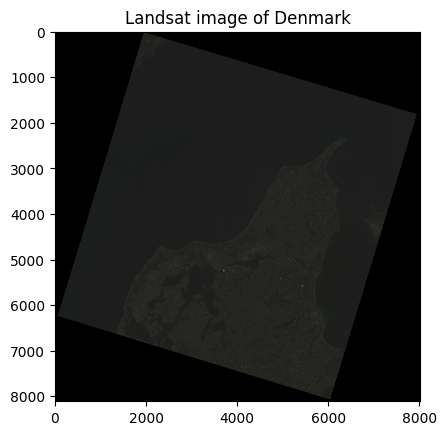

In [5]:
plt.imshow(img_rgb)
plt.title('Landsat image of Denmark')
plt.show()

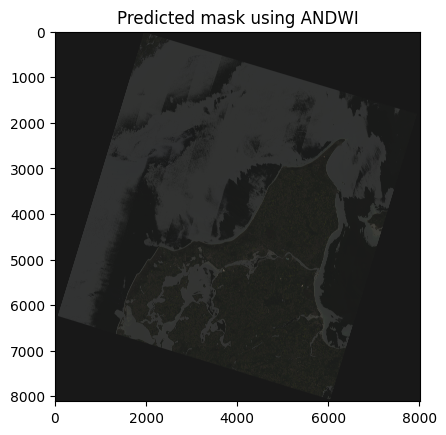

In [6]:
plt.imshow(img_rgb)
plt.imshow(mask_andwi, alpha = 0.1, cmap = 'gray') 
plt.title('Predicted mask using ANDWI')
plt.show()

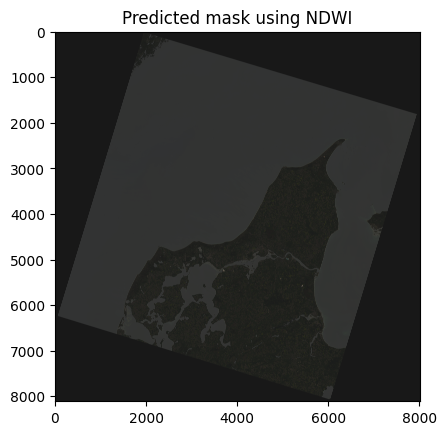

In [7]:
plt.imshow(img_rgb)
plt.imshow(mask_ndwi, alpha = 0.1, cmap = 'gray')
plt.title('Predicted mask using NDWI')
plt.show()

In [8]:
img_rgb.shape, mask_ndwi.shape

((8111, 8021, 3), (8111, 8021))

In [9]:
img_width, img_height = 256, 256
I, J = mask_ndwi.shape

In [10]:
# Prepare folders to store the annotated data in
base_folder = 'denmark_landsat_data'
os.makedirs(base_folder, exist_ok = True)
# Create the 'splits' - here we only use the test split as we only evaluate on the Danish data
for split in ['test']: #['train', 'val', 'test']:
    os.makedirs(f'{base_folder}/{split}', exist_ok = True)
    os.makedirs(f'{base_folder}/{split}/msk', exist_ok = True)
    os.makedirs(f'{base_folder}/{split}/img', exist_ok = True)

In [11]:
# if img_full.shape[0] != 7:
#     img_full = img_full.transpose(2,0,1)

In [12]:
img_full.shape, mask_ndwi.shape

((6, 8111, 8021), (8111, 8021))

In [13]:
success = 0
idx = 0
chosen_splits = []
num_channels = img_full.shape[0]
for i in tqdm(range(0, I-img_width, img_width)):
    for j in range(0, J, img_height):
        x_start, y_start = i, j

        # Define the bounds of the image and mask, then crop them
        x_end, y_end = i + img_width, j + img_height
        mask_crop = mask_ndwi[x_start:x_end, y_start:y_end].astype(int)
        img_crop = img_full[:, x_start:x_end, y_start:y_end]
        # print('img', img_crop.shape, 'mask', mask_crop.shape)
        # Ensure we have the right shape
        if mask_crop.shape != (img_width, img_height):
            # print('continue')
            continue
        # Only keep images with some amount of water in them for simplicity
        if np.where(mask_crop == 1)[0].shape == (0,):
            continue
        success += 1
        # Choose which split to assign the image and mask to, using weighted randomness
        # Since we just use the Danish data as test data, I have set it to 100% test set
        splits = ['test'] # * 25 + ['val'] * 25 + ['train'] * 50
        chosen_split = random.choice(splits)
        chosen_splits.append(chosen_split)

        # Save the mask as a numpy array
        np.save(f'{base_folder}/{chosen_split}/msk/{idx}.npy', mask_crop)

        # Make a new TIF file with the right properties in terms of bounds, transforms, etc.
        x_min, y_min = rasterio.transform.xy(channel_tif.transform, x_start, y_start)
        x_max, y_max = rasterio.transform.xy(channel_tif.transform, x_end, y_end)
        transform = rasterio.transform.from_bounds(x_min, y_min, x_max, y_max, x_end - x_start, y_end - y_start)
    
        with rasterio.open(f'{base_folder}/{chosen_split}/img/{idx}.tif', 'w', driver = 'GTiff', width = img_crop.shape[2], height = img_crop.shape[1],
                            count = num_channels,  dtype = img_crop.dtype, crs = channel_tif.crs, transform = transform) as f:
            for c in range(num_channels): # Write the color channels to the tif file
                f.write(img_crop[c], c + 1)
        idx += 1
print(success)

100%|███████████████████████████████████████████████████████████████████████████████████| 31/31 [00:27<00:00,  1.12it/s]

948


In [14]:
left, bottom, right, top = channel_tif.bounds
width_meter = right-left
height_meter = top-bottom
print(width_meter, height_meter)
width_pixel, height_pixel = I, J

width_meter/height_pixel, height_meter/width_pixel # is this in meters or cm??

240630.0 243330.0


(30.0, 30.0)

In [15]:
import rasterio
from rasterio.transform import from_origin

# Open the raster file
with channel_tif as dataset:
    transform = dataset.transform
    crs = dataset.crs

    # Print the transform matrix
    print("Transform matrix:", transform)

    # Extract pixel size from the transform
    pixel_width = transform[0]
    pixel_height = -transform[4]  # The pixel height is often negative

    # Calculate pixel area
    pixel_area = pixel_width * pixel_height

    print(f"Pixel width: {pixel_width} {crs.linear_units}")
    print(f"Pixel height: {pixel_height} {crs.linear_units}")
    print(f"Pixel area: {pixel_area} square {crs.linear_units}")

Transform matrix: | 30.00, 0.00, 407085.00|
| 0.00,-30.00, 6473115.00|
| 0.00, 0.00, 1.00|
Pixel width: 30.0 metre
Pixel height: 30.0 metre
Pixel area: 900.0 square metre


In [16]:
import sys
sys.path.append('./UNet_code')
from data_loader import CustomDataLoader
from torch.utils.data import DataLoader

# Get the test dataset
data_path = './denmark_landsat_data'
image_path = data_path + '/{}/img/*'
mask_path = data_path + '/{}/msk/*'

channels = 'r.g.b'
 
# Use custom data loaders for the dataset
test_dataset = CustomDataLoader(image_path.format('test'), mask_path.format('test'), channels = channels)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False, num_workers = 8)

In [17]:
import torch
landsat_data = {'r': [], 'g': [], 'b': []}

for batch in tqdm(test_loader):
    img, label = batch
    img = img.to(torch.float16).cpu().numpy()
    img = img.reshape(3, -1)
    for i, channel in enumerate(landsat_data):
        landsat_data[channel].extend(np.random.choice(img[i, :], int(img.shape[-1]/5), replace = False))
        landsat_data[channel].extend(img[i, :])
        

100%|█████████████████████████████████████████████████████████████████████████████████| 119/119 [00:59<00:00,  1.99it/s]


In [ ]:
%%time
import matplotlib.pyplot as plt
plt.hist(landsat_data['r'], bins = 100, color = 'r', label = 'R', alpha = 0.3)
plt.hist(landsat_data['g'], bins = 100, color = 'g', label = 'G', alpha = 0.3)
plt.hist(landsat_data['b'], bins = 100, color = 'b', label = 'B', alpha = 0.3)
plt.xlim(0, 1)
plt.ylim(0, 2.2e7)
plt.ylabel('Frequency')
plt.xlabel('Value (normalized)')
plt.title('Distribution of RGB values of the Landsat dataset (outliers removed)')
plt.legend()
plt.savefig(f'./images/landsat_water_RGB.png', bbox_inches='tight', transparent=True)
plt.show()

del landsat_data # Clear up memory